## Speckle Data Pack
### Concrete And Cement Content
This example explains how to get quantities and types of windows accross the whole portfolio.

In [1]:
%%capture
# capture turns off the output for this cell which would just be the pip install log
%pip install specklepy
%pip install pandas
%pip install pandasai

In [2]:
from specklepy.api.wrapper import StreamWrapper

# Speckle Data Pack I project (stream) link
stream_url = "https://speckle.xyz/streams/729cb7c74b"

# wrapper
wrapper = StreamWrapper(stream_url)


In [3]:
from specklepy.api import operations

# get project (stream) data
stream = wrapper.get_client().stream.get(id=wrapper.stream_id, branch_limit=40)

data = []

# models (branches) to skip
exclude_models = ['main', 'all_in_one']

for branch in stream.branches.items:
    
    if branch.commits.items and branch.name not in exclude_models:
        # get obj id from the latest version (commit)
        obj_id = branch.commits.items[0].referencedObject

        # receive objects from speckle
        commit_data = operations.receive(
            obj_id=obj_id, remote_transport=wrapper.get_transport()
        )
        data.append([commit_data, branch.name])
    

In [4]:
# get list of window family definitions accros all Revit models, these are not actual instances placed

window_families = []

for item in data:
    
    types = item[0]['@Types']['@Windows']

    for t in types:
        wt = t['family'] + ' - ' + t['type']
        if wt not in window_families:
            window_families.append(wt)

window_families

['M_Fixed - 0406 x 0610mm',
 'M_Fixed - 0406 x 1220mm',
 'M_Fixed - 0610 x 0610mm',
 'M_Fixed - 0610 x 1220mm',
 'M_Fixed - 0915 x 0610mm',
 'M_Fixed - 0915 x 1220mm',
 'M_Fixed - 0406 x 1830mm',
 'M_Fixed - 0610 x 1830mm',
 'M_Fixed - 0915 x 1830mm',
 'M_Window-Double-Hung - 600 x 1100mm',
 'M_Window-Double-Hung - 650 x 1100mm',
 'M_Window-Double-Hung - 700 x 1200mm',
 'M_Window-Double-Hung - 750 x 1200mm',
 'M_Window-Casement-Double - 850 x 900mm',
 'M_Window-Casement-Double - 1050 x 1350mm',
 'M_Window-Casement-Double - 1200 x 1500mm',
 'M_Window-Casement-Double - 1400 x 1800mm',
 'Windows_Sgl_Plain - 910x910mm',
 'Windows_Sgl_Plain - 910x1210mm',
 'Windows_Sgl_Plain - 1360x910mm',
 'Windows_Sgl_Plain - 1360x1210mm',
 'Windows_Sgl_Plain - 1810x910mm',
 'Windows_Sgl_Plain - 1810x1210mm',
 'M_Window-Fixed - 600 x 900mm',
 'M_Window-Fixed - 600 x 1500mm',
 'M_Window-Fixed - 750 x 900mm',
 'M_Window-Fixed - 750 x 1650mm',
 'M_Window-Fixed - 900 x 1200mm',
 'M_Window-Fixed - 900 x 1650mm

In [5]:
# create data table

import pandas as pd

table = {'Type':[], 'Size':[], 'Level':[], 'Model':[]}

# object types to look for, walls are host elements
types = ['Walls']

for item in data: 

    elements = item[0]['elements']

    # get type collections
    for element in elements:
        if element['name'] in types:
            for el in element['elements']:
                # check if wall has hosted elements 
                if el['elements']:
                    for e in el['elements']:
                        if e['category'] == 'Windows':
                            table['Type'].append(e['definition']['family'] + ' - ' + e['definition']['type'])
                            table['Size'].append(e['definition']['type'])
                            table['Level'].append(e['level']['name'])
                            table['Model'].append(item[1])

# create data frame 
df = pd.DataFrame(table)

In [6]:
# number of window types in all models
df['Type'].value_counts()


M_Fixed - 0915 x 0610mm                     80
Windows_Sgl_Plain - 1360x1210mm             64
Windows_Sgl_Plain - 1360x910mm              64
M_Window-Casement-Double - 1200 x 1500mm    64
M_Fixed - 0610 x 1220mm                     48
M_Window-Double-Hung - 650 x 1100mm         48
M_Window-Fixed - 900 x 1200mm               48
M_Fixed - 0406 x 1830mm                     32
Windows_Sgl_Plain - 1810x910mm              32
Name: Type, dtype: int64

In [7]:
# get area from size column

# strip mm
df['Size'] = df['Size'].str.strip('mm')

# split size column and create new width and height columns
df[['Width', 'Height']] = df['Size'].str.split('x', expand=True)

# convert to numbers
df['Width'] = pd.to_numeric(df['Width'])
df['Height'] = pd.to_numeric(df['Height'])

# calculate area and convert to square meters
df['Area'] = df['Width'] * df['Height'] * 0.000001

df.head()

,Type,Size,Level,Model,Width,Height,Area
0,M_Fixed - 0915 x 0610mm,0915 x 0610,Level1,sb2201,915,610,0.55815
1,M_Fixed - 0915 x 0610mm,0915 x 0610,Level1,sb2201,915,610,0.55815
2,M_Fixed - 0915 x 0610mm,0915 x 0610,Level2,sb2201,915,610,0.55815
3,M_Fixed - 0915 x 0610mm,0915 x 0610,Level2,sb2201,915,610,0.55815
4,M_Fixed - 0915 x 0610mm,0915 x 0610,Level2,sb2201,915,610,0.55815


<Axes: xlabel='Model', ylabel='windows area per model m²'>

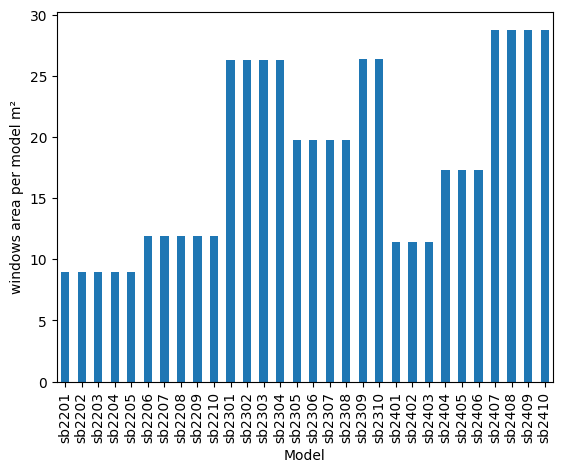

In [8]:
df.groupby('Model')['Area'].sum().round(3).plot(ylabel='windows area per model m²', kind='bar')

PandasAI integrates LLMs so you can simply as questions and in this case, ChatGPT will answer.

In [9]:
# load environment variables 
from decouple import config


In [10]:
import pandas as pd
from pandasai import SmartDataframe

# Instantiate a LLM
from pandasai.llm.openai import OpenAI
llm = OpenAI(api_token=config('OPENAI_TOKEN'))

df = SmartDataframe(df, config={"llm": llm})

In [11]:
df.chat('Which model has the largest window area')

'The model with the largest window area is sb2407.'

In [12]:
df.chat('Which window type has the largest area')

'The model with the largest window area is sb2407. The window type with the largest area is M_Window-Casement-Double - 1200 x 1500mm.'